# In this notebook I will Try to connect the rag model for pdf ingestion and use pinecone as vector database


In [2]:
# We will be using these PDF loaders but you can check out other loaded documents
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import UnstructuredPDFLoader
from rich import print
import re
from transformers import AutoTokenizer
from dotenv import load_dotenv
import os
from pinecone import Pinecone, ServerlessSpec
from uuid import uuid4

os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

load_dotenv()

EMBEDDING_MODEL = "sentence-transformers/paraphrase-MiniLM-L6-v2"

# This is the name of the report which should be in the directory
# You can download the precise PDF I am using from here https://www.pc.gov.pk/uploads/archives/PSDP_2023-24.pdf

name = '../data/raw/Easy_recipes.pdf'

# This loader uses PyMuPDF
loader_py = PyMuPDFLoader(name)

# Storing the loaded documents as langChain Document object
pages_py = loader_py.load()


In [3]:
print(pages_py[0].page_content)
print(len(pages_py))

Quick     and     easy    recipes         
          
Start     cooking         today!          
You       can     do      it!     
          
Cooking   meals   is      much    cheaper         than    eating          outside.        This    is      true    
everywhere      
but       even    more    in      Geneva...       Take    turns   and     cook    for     your    roommate        
and     your    
friends!          You’ll          save    even    more    money   –       and     the     kitchen         will    
probably        stay    
cleaner...        
          
I         have    selected        only    a       few     recipes         from    these   websites:       
http://www.studentrecipes.com/    
http://www.squidoo.com/studentfood#module55467342         
          
          
Bon       appétit!

15

In [4]:
# text splitter
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    # shows how to seperate
    separator="\n",
    # Shows the document token length
    chunk_size=1000,
    # How much overlap should exist between documents
    chunk_overlap=200,
    # How to measure length
    length_function=len
)

# Applying the splitter
docs = text_splitter.split_documents(pages_py)

print(docs[0])
print(len(docs))

Document(
    metadata={
        'producer': 'Mac OS X 10.6.4 Quartz PDFContext',
        'creator': 'Microsoft Word',
        'creationdate': "D:20100809161642Z00'00'",
        'source': '../data/raw/Easy_recipes.pdf',
        'file_path': '../data/raw/Easy_recipes.pdf',
        'total_pages': 15,
        'format': 'PDF 1.3',
        'title': 'Easy recipes',
        'author': 'sylvie meynier',
        'subject': '',
        'keywords': '',
        'moddate': "D:20100809161642Z00'00'",
        'trapped': '',
        'page': 0
    },
    page_content='Quick\t\r \xa0and\t\r \xa0easy\t\r \xa0recipes\t\r \xa0\n\t\r \xa0\nStart\t\r \xa0cooking\t\r 
\xa0today!\t\r \xa0\nYou\t\r \xa0can\t\r \xa0do\t\r \xa0it!\t\r \xa0\n\t\r \xa0\nCooking\t\r \xa0meals\t\r 
\xa0is\t\r \xa0much\t\r \xa0cheaper\t\r \xa0than\t\r \xa0eating\t\r \xa0outside.\t\r \xa0This\t\r \xa0is\t\r 
\xa0true\t\r \xa0everywhere\t\r \xa0\nbut\t\r \xa0even\t\r \xa0more\t\r \xa0in\t\r \xa0Geneva...\t\r \xa0Take\t\r 
\xa0turns\t\r \xa0and\t\r \xa0cook\t\r \xa0for\t\r \xa0your\t\r \xa0roommate\t\r \xa0and\t\r \xa0your\t\r 
\xa0\nfriends!\t\r \xa0You’ll\t\r \xa0save\t\r \xa0even\t\r \xa0more\t\r \xa0money\t\r \xa0–\t\r \xa0and\t\r 
\xa0the\t\r \xa0kitchen\t\r \xa0will\t\r \xa0probably\t\r \xa0stay\t\r \xa0\ncleaner...\t\r \xa0\n\t\r \xa0\nI\t\r 
\xa0have\t\r \xa0selected\t\r \xa0only\t\r \xa0a\t\r \xa0few\t\r \xa0recipes\t\r \xa0from\t\r \xa0these\t\r 
\xa0websites:\t\r \xa0\nhttp://www.studentrecipes.com/\t\r 
\xa0\nhttp://www.squidoo.com/studentfood#module55467342\t\r \xa0\n\t\r \xa0\n\t\r \xa0\nBon\t\r \xa0appétit!'
)

29

In [5]:
def clean_text(text):
    # Remove non-printable characters
    text = re.sub(r'[^\x20-\x7E]', '', text)
    
    # Remove excessive spaces, newlines, and tabs
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove unwanted special characters but keep medical symbols
    text = re.sub(r'[^\w\s.,:;/%°±()\-]', '', text)  
    text = re.sub(r'[\t\r\xa0]', ' ', text)  # Replace \t, \r, and \xa0 with a space
    text = re.sub(r'\n+', '\n', text)  # Keep meaningful line breaks
    text = re.sub(r' +', ' ', text).strip()  # Remove excessive space

    return text  

In [6]:
from langchain_core.documents import Document
docs = [Document(clean_text(doc.page_content),metadata=doc.metadata) for doc in docs]

In [7]:
print(docs[0])

Document(
    metadata={
        'producer': 'Mac OS X 10.6.4 Quartz PDFContext',
        'creator': 'Microsoft Word',
        'creationdate': "D:20100809161642Z00'00'",
        'source': '../data/raw/Easy_recipes.pdf',
        'file_path': '../data/raw/Easy_recipes.pdf',
        'total_pages': 15,
        'format': 'PDF 1.3',
        'title': 'Easy recipes',
        'author': 'sylvie meynier',
        'subject': '',
        'keywords': '',
        'moddate': "D:20100809161642Z00'00'",
        'trapped': '',
        'page': 0
    },
    page_content='Quick and easy recipes Start cooking today You can do it Cooking meals is much cheaper than 
eating outside. This is true everywhere but even more in Geneva... Take turns and cook for your roommate and your 
friends Youll save even more money and the kitchen will probably stay cleaner... I have selected only a few recipes
from these websites: http://www.studentrecipes.com/ http://www.squidoo.com/studentfoodmodule55467342 Bon apptit'
)

In [8]:
embeddings=AutoTokenizer.from_pretrained(EMBEDDING_MODEL)

In [9]:
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
print(pinecone_api_key)
pc = Pinecone(api_key=pinecone_api_key)

pcsk_7PvMU4_15gJfjME25FYrtL2aWQR9k63AkdNHWynw3ZLXnPJ1kFVggdkLMRpESv5ajdTNfF

In [25]:
import time

index_name = "test2-index-legal"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
print(existing_indexes)

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=1024,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)
print(index)

['test3-index-legal', 'test2-index-legal', 'test-index-legal']

<pinecone.data.index.Index object at 0x000001CBDD662260>

In [11]:
# create embeddings and upload to pinecone

In [ ]:
import numpy as np
from uuid import uuid4

# Generate embeddings for the documents using multilingual-e5-large
embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[doc.page_content for doc in docs],
    parameters={"input_type": "passage", "truncate": "END"}
)


vectors = []
for i, (doc, embedding) in enumerate(zip(docs, embeddings)):
    vector = {
        "id": str(uuid4()),  # Generate a unique ID for each vector
        "values": embedding['values'],  # Ensure embedding values are correctly extracted
        "metadata": {
            "text": doc.page_content,
            **doc.metadata  # Include all metadata from the document
        }
    }
    vectors.append(vector)

# Upload vectors to Pinecone
index.upsert(
    vectors=vectors,
)


AttributeError: 'Index' object has no attribute 'name'

In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")


c:\Users\naran\anaconda3\envs\legal_env\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [14]:
print(prompt)

ChatPromptTemplate(
    input_variables=['context', 'question'],
    input_types={},
    partial_variables={},
    metadata={
        'lc_hub_owner': 'rlm',
        'lc_hub_repo': 'rag-prompt',
        'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'
    },
    messages=[
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=['context', 'question'],
                input_types={},
                partial_variables={},
                template="You are an assistant for question-answering tasks. Use the following pieces of retrieved 
context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences 
maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"
            ),
            additional_kwargs={}
        )
    ]
)

In [19]:
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages)

[
    HumanMessage(
        content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context 
to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and
keep the answer concise.\nQuestion: (question goes here) \nContext: (context goes here) \nAnswer:",
        additional_kwargs={},
        response_metadata={}
    )
]

In [20]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

In [27]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-roberta-large-v1")

In [28]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

index_name1 = "test3-index-legal"  # change if desired
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
if index_name1 not in existing_indexes:
    pc.create_index(
        name=index_name1,
        dimension=1024,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name1).status["ready"]:
        time.sleep(1)
index = pc.Index(index_name1)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [29]:
_ = vector_store.add_documents(documents=docs)

In [30]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [32]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=10)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [41]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Summarize the information in the context"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [42]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `query_or_respond` already present.

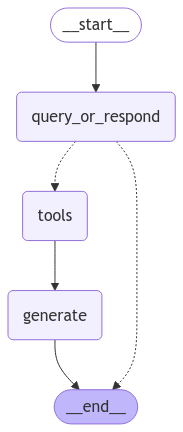

In [43]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
input_message = "Summarize the information stored in database"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

In [45]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [46]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_6xnq)
 Call ID: call_6xnq
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'sylvie meynier', 'creationdate': "D:20100809161642Z00'00'", 'creator': 'Microsoft Word', 'file_path': '../data/raw/Easy_recipes.pdf', 'format': 'PDF 1.3', 'keywords': '', 'moddate': "D:20100809161642Z00'00'", 'page': 0.0, 'producer': 'Mac OS X 10.6.4 Quartz PDFContext', 'source': '../data/raw/Easy_recipes.pdf', 'subject': '', 'title': 'Easy recipes', 'total_pages': 15.0, 'trapped': ''}
Content: Quick and easy recipes Start cooking today You can do it Cooking meals is much cheaper than eating outside. This is true everywhere but even more in Geneva... Take turns and cook for your room

In [47]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

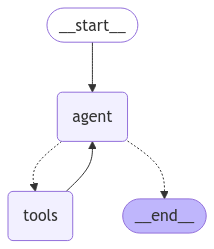

In [48]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [51]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "Summarize all data in database\n\n"
    "Once you get the answer, refine it "
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Summarize all data in database

Once you get the answer, refine it 
================================== Ai Message ==================================

To summarize all data in a database, one common method is to use a combination of techniques such as:

1. Data aggregation: Grouping data into categories or subsets based on common attributes or characteristics.
2. Data summarization: Reducing data to its most important or relevant information, such as averages, totals, or counts.
3. Data visualization: Representing data in a graphical or chart format to make it easier to understand and analyze.

Here's a step-by-step approach to summarizing data in a database:

1. Identify the data: Determine what data you want to summarize and why.
2. Clean and preprocess the data: Remove any unnecessary data, correct errors, and transform the data into a suitable format for analysis.
3. Apply data aggregation: Group the d

In [53]:
# %% Add a new summarization tool
@tool(response_format="content_and_artifact")
def summarize_database(query: str = "Provide summary of all content"):
    """Summarizes comprehensive content from the database. Use this when asked for overviews or summaries."""
    # Retrieve more documents for better context
    retrieved_docs = vector_store.similarity_search(query, k=20)  # Increased from 10 to 20
    combined_content = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}" 
        for doc in retrieved_docs
    )
    
    # Specialized summarization prompt
    prompt = [
        SystemMessage(
            "You are a legal document summarization expert. Create a comprehensive summary "
            "that includes key points, notable cases, and critical legal interpretations from "
            "these documents:\n\n" + combined_content
        )
    ]
    summary = llm.invoke(prompt)
    return summary.content, retrieved_docs

# %% Update your agent with both tools
agent_executor = create_react_agent(
    llm, 
    [retrieve, summarize_database],  # Add new summarization tool
    checkpointer=memory
)

# %% You can now use either tool
input_message = "Summarize all legal documents in the database"

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={"configurable": {"thread_id": "summary123"}},
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Summarize all legal documents in the database
================================== Ai Message ==================================
Tool Calls:
  summarize_database (call_njwa)
 Call ID: call_njwa
  Args:
    query: Provide summary of all legal documents
================================= Tool Message =================================
Name: summarize_database

**Summary of Easy Recipes**

The documents provided contain a collection of easy recipes, including dishes such as Chilli con Carne, Beef in Beer, Pad Thai Chicken, Thai Green Curry, and many more. The recipes are simple to follow and require minimal ingredients and cooking skills.

**Key Points:**

1. Most recipes can be prepared in under 30 minutes and require minimal ingredients.
2. Many recipes can be cooked in a single pan or casserole dish, making cleanup easy.
3. Some recipes, such as the Chilli con Carne, can be made in bulk and stored in the frid